<a href="https://colab.research.google.com/github/alecbidaran/Pytorch_excersies/blob/main/visual_trasformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch-snippets

     |████████████████████████████████| 44 kB 1.6 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 224 kB 27.9 MB/s 
     |████████████████████████████████| 10.9 MB 44.3 MB/s 
     |████████████████████████████████| 58 kB 2.0 MB/s 
     |████████████████████████████████| 51 kB 4.5 MB/s 


In [1]:
import torch 
from torchvision import transforms,datasets
from torch_snippets import *
import numpy as np 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import torchvision.models as models
from collections import OrderedDict

In [2]:
train_transform=transforms.Compose([transforms.Resize((32,32)),
                                  transforms.RandomRotation(0.2),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
valid_transform=transforms.Compose([
                                    transforms.Resize((32,32)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
test_transform=transforms.Compose([transforms.Resize((32,32)),
                                  transforms.RandomRotation(0.4),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [3]:
train_dataset=datasets.CIFAR100(root="./data",download=True,train=True,transform=train_transform)
valid_dataset=datasets.CIFAR100(root="./data",download=True,train=False,transform=train_transform)

Files already downloaded and verified
Files already downloaded and verified


In [50]:
class transformer_block(torch.nn.Module):
  def __init__(self,in_dim,num_head):
    super(transformer_block,self).__init__()
    self.mha=torch.nn.MultiheadAttention(in_dim,num_head)
    self.lnorm=torch.nn.LayerNorm(in_dim)
    self.flatten=torch.nn.Flatten()
    self.gelu=torch.nn.GELU()
    self.linear=torch.nn.Linear(4096,4096)
    #self.lnorm1=torch.nn.LayerNorm(x.shape[1])
  def forward(self,x):
    norm=self.lnorm(x)
    msa,_=self.mha(norm,norm,norm)
    norm=self.lnorm(msa)
    x=norm+x
    x=self.flatten(x)
    x1=torch.nn.LayerNorm(x.shape[-1]).to(device)(x)
    l1=self.linear(x1)
    l1=self.gelu(l1)
    l1=self.linear(l1)
    out=l1+x
    return out.view(-1,4,1024)


In [51]:
tranformer=transformer_block(1024,16).to(device)

In [52]:
summary(tranformer,(4,1024))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         LayerNorm-1              [-1, 4, 1024]           2,048
MultiheadAttention-2  [[-1, 4, 1024], [-1, 2, 2]]               0
         LayerNorm-3              [-1, 4, 1024]           2,048
           Flatten-4                 [-1, 4096]               0
            Linear-5                 [-1, 4096]      16,781,312
              GELU-6                 [-1, 4096]               0
            Linear-7                 [-1, 4096]      16,781,312
Total params: 33,566,720
Trainable params: 33,566,720
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.06
Params size (MB): 128.05
Estimated Total Size (MB): 128.12
----------------------------------------------------------------


In [53]:
class VIT(torch.nn.Module):
  def __init__(self,num_classes=100):
    super(VIT,self).__init__()
    #self.patch=torch.nn.Conv2d(512,256,1)
    self.flatten=torch.nn.Flatten()
    self.patches=torch.nn.Unfold(kernel_size=16,stride=16,padding=1)
    #self.lnorm=torch.nn.LayerNorm(768)
    self.transformer=torch.nn.Sequential(*[transformer_block(1024,16) for _ in range(12)])
    #self.transformer_encoder=torch.nn.Sequential(*[torch.nn.TransformerEncoderLayer(768,12,dim_feedforward=3072,dropout=0.1,batch_first=False) for _ in range(12)])
    self.projection=torch.nn.Linear(768,1024)
    self.mlp=torch.nn.Sequential(
                                 torch.nn.Linear(4096,100))
  def forward(self,x):
    #x=self.backbone(x)
    x=self.patches(x).transpose(-2,-1)
    #x=self.flatten(x)
    x=self.projection(x)
    embedding=torch.nn.Embedding(16,1024,device=device)
    pos=torch.arange(0,(32//16)**2).to(device).long()
    pos_enc=embedding(pos.unsqueeze(0))
    for i in range(1024,2):
      wk=0.0001**(2*i*1024/16)
      x[i]+=torch.sin(pos_enc.squeeze(0)*wk)
      x[i+1]+=torch.cos(pos_enc.squeeze(0)*wk)
    #x1=self.lnorm(x)
    x1=self.transformer(x)
    x1=self.flatten(x1)
    x2=self.mlp(x1)
    return x2

In [54]:
model=VIT(num_classes=100).to(device)


In [55]:
from torchsummary import summary

In [56]:
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Unfold-1               [-1, 768, 4]               0
            Linear-2              [-1, 4, 1024]         787,456
         LayerNorm-3              [-1, 4, 1024]           2,048
MultiheadAttention-4  [[-1, 4, 1024], [-1, 2, 2]]               0
         LayerNorm-5              [-1, 4, 1024]           2,048
           Flatten-6                 [-1, 4096]               0
            Linear-7                 [-1, 4096]      16,781,312
              GELU-8                 [-1, 4096]               0
            Linear-9                 [-1, 4096]      16,781,312
transformer_block-10              [-1, 4, 1024]               0
        LayerNorm-11              [-1, 4, 1024]           2,048
MultiheadAttention-12  [[-1, 4, 1024], [-1, 2, 2]]               0
        LayerNorm-13              [-1, 4, 1024]           2,048
          Flatten-14              

In [57]:

def train_batch(batch,model,loss_fn,optimizer):
  image,label=batch
  image,label=image.to(device),label.to(device)
  optimizer.zero_grad()
  logit=model(image)
  loss=loss_fn(logit,label)
  loss.backward()
  optimizer.step()
  acc=(torch.max(logit,1)[1]==label).float().mean()
  return loss.item(),acc.item()
@torch.no_grad()
def valid_batch(batch,model,loss_fn):
  model.eval()
  image,label=batch
  image,label=image.to(device),label.to(device)
  logit=model(image)
  loss=loss_fn(logit,label)
  acc=(torch.max(logit,1)[1]==label).float().mean()
  return loss.item(),acc.item()

In [58]:
trn_dl=torch.utils.data.DataLoader(train_dataset,batch_size=256,shuffle=True)
val_dl=torch.utils.data.DataLoader(valid_dataset,batch_size=256,shuffle=False)

In [59]:
loss_fn=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [60]:
n_epoch=30
log=Report(n_epoch)
for epochs in range(n_epoch):
  N = len(trn_dl)
  for i,data in enumerate(trn_dl):
    loss,acc=train_batch(data,model,loss_fn,optimizer)
    log.record(epochs+(i+1)/N,trn_loss=loss,trn_acc=acc,end='\r')
  N = len(val_dl)
  for b,data in enumerate(val_dl):
    loss,acc=valid_batch(data,model,loss_fn)
    log.record(epochs+(b+1)/N,val_loss=loss,val_acc=acc,end='\r')
  if epochs>=10:
    optimizer=torch.optim.Adam(model.parameters(),lr=0.001) 
  log.report_avgs(epochs+1)

EPOCH: 1.000	trn_loss: 15.122	trn_acc: 0.056	val_loss: 4.167	val_acc: 0.101	(197.13s - 5716.84s remaining)
EPOCH: 2.000	trn_loss: 3.840	trn_acc: 0.139	val_loss: 3.831	val_acc: 0.142	(394.18s - 5518.53s remaining)
EPOCH: 3.000	trn_loss: 3.538	trn_acc: 0.181	val_loss: 3.664	val_acc: 0.173	(591.69s - 5325.20s remaining)
EPOCH: 4.000	trn_loss: 3.334	trn_acc: 0.214	val_loss: 3.509	val_acc: 0.196	(788.66s - 5126.26s remaining)
EPOCH: 5.000	trn_loss: 3.132	trn_acc: 0.248	val_loss: 3.532	val_acc: 0.205	(985.69s - 4928.45s remaining)
EPOCH: 6.000	trn_loss: 2.970	trn_acc: 0.278	val_loss: 3.525	val_acc: 0.219	(1182.70s - 4730.79s remaining)
EPOCH: 7.000	trn_loss: 2.760	trn_acc: 0.313	val_loss: 3.470	val_acc: 0.230	(1379.33s - 4532.07s remaining)
EPOCH: 8.000	trn_loss: 2.648	trn_acc: 0.340	val_loss: 3.651	val_acc: 0.219	(1575.94s - 4333.83s remaining)
EPOCH: 9.000	trn_loss: 2.463	trn_acc: 0.380	val_loss: 3.795	val_acc: 0.231	(1772.83s - 4136.61s remaining)
EPOCH: 10.000	trn_loss: 2.275	trn_acc: 0.

KeyboardInterrupt: ignored

100%|██████████| 131/131 [00:00<00:00, 507.52it/s]


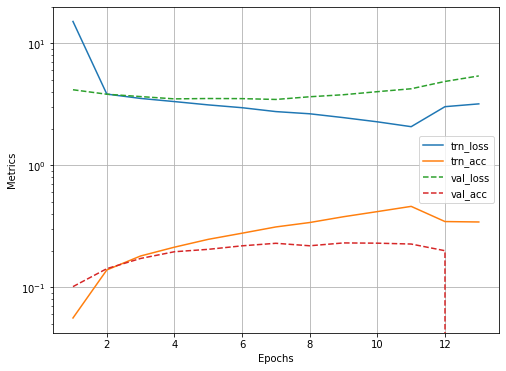

In [61]:
log.plot_epochs(log=True)